# AI Project: Recommender System for Netflix Movies and TV Show

## Globals and Imports

In [151]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Load the data / Data Exploration

In [152]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Columns with missing values and their counts

In [153]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

### We will need to fill the missing values in key text columns with empty strings
#### This prevents errors when we combine them later.

In [154]:
text_columns = ['director', 'cast', 'country', 'rating', 'duration']
for col in text_columns:
    df[col] = df[col].fillna('')

df['date_added'] = df['date_added'].fillna('')

C:\Users\nickp\AppData\Local\Temp\ipykernel_20524\2803392682.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='viridis')


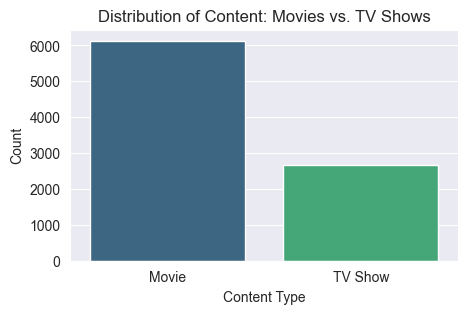

In [155]:
# Distribution of Content Type
sns.set_style('darkgrid')

plt.figure(figsize=(5, 3))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Distribution of Content: Movies vs. TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.savefig('content_type_distribution.png') 

C:\Users\nickp\AppData\Local\Temp\ipykernel_20524\1487783645.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='mako')


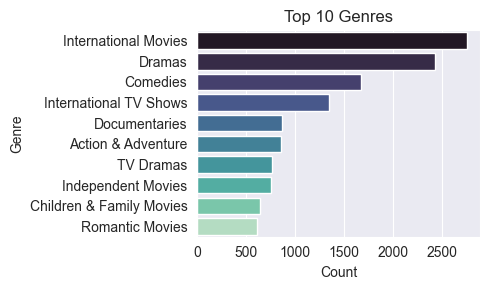

In [156]:
# Top 10 Genres
plt.figure(figsize=(5, 3))
top_10_genres = df['listed_in'].str.split(', ').explode().value_counts().iloc[:10]
#sns.countplot(y=genre_data, order=genre_data.value_counts().iloc[:10].index, palette='mako')
sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='mako')

plt.title('Top 10 Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('top_10_genres.png')


### Create a 'content' column by combining the key text features

In [157]:
# For each movie, combine director, cast, genres, and description into a single string.
# We use .lower() to ensure all text is lowercase for consistency.
df['content'] = df['director'].str.lower() + ' ' + df['cast'].str.lower() + ' ' + df['listed_in'].str.lower() + ' ' + df['description'].str.lower()

In [158]:
# Convert Text to Numbers (TF-IDF Vectorization) 
tfidf = TfidfVectorizer(stop_words='english')
count_vec = CountVectorizer(stop_words='english')
# Apply the vectorizer to our 'content' column.
# This creates a large matrix where each row is a movie and each column is a word's TF-IDF score.
tfidf_matrix = tfidf.fit_transform(df['content'])
count_matrix = count_vec.fit_transform(df['content'])

print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

Shape of TF-IDF matrix: (8807, 49941)


###### After we've got the vectorized the text data into a matrix, we apply a cosine similarity function to quantify how similar the new data is based on their directions. Cosine similarity measures the cosine of the angle between two vectors, providing a way to quantify how similar their directions are, regardless of their magnitudes.

In [159]:
# Calculate the cosine similarity between all movie vectors (the value passed to our recommendation function)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
count_cosine_sim = cosine_similarity(count_matrix, count_matrix)
euclidean_dist = euclidean_distances(tfidf_matrix)
print("Euclidean distance matrix created successfully.")
print(f"Shape of cosine similarity matrix: {cosine_sim.shape}")

Euclidean distance matrix created successfully.
Shape of cosine similarity matrix: (8807, 8807)


In [160]:
# Create a pandas Series of movie titles with their corresponding index
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    """
    This function takes a movie title and returns a DataFrame with the
    top 10 most similar movies and their similarity scores.
    """
    try:
        idx = indices[title]
    except KeyError:
        return f"Error: Movie '{title}' not found in the dataset."

    sim_scores = list(enumerate(cosine_sim[idx]))    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)    # Sort the movies based on the similarity scores
    sim_scores = sim_scores[1:6]# Get the scores of the 5 most similar movies
    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    recommendations_df = pd.DataFrame({
        'Title': df['title'].iloc[movie_indices],
        'Similarity Score': similarity_scores
    })
    
    return recommendations_df

# movie_title = "Jaws"
# recommendations = get_recommendations(movie_title)
# print(f"Recommendations for '{movie_title}':")
# print(recommendations)


In [161]:
def get_recommendations_by_distance(title, distance_matrix):
    """
    This function takes a movie title and returns the top 10 closest movies
    based on a distance metric (where lower is better).
    """
    try:
        idx = indices[title]
    except KeyError:
        return f"Error: Movie '{title}' not found in the dataset."
    
    dist_scores = list(enumerate(distance_matrix[idx])) # Get the pairwise distance scores
    dist_scores = sorted(dist_scores, key=lambda x: x[1], reverse=False)# Sort the movies based on the distance scores (ascending, since lower is better)
    dist_scores = dist_scores[1:11] # Get the scores of the 10 closest movies (index 0 is the movie itself)
    movie_indices = [i[0] for i in dist_scores]# Get the movie indices and their scores
    distance_scores = [i[1] for i in dist_scores]

    recommendations_df = pd.DataFrame({
        'Title': df['title'].iloc[movie_indices],
        'Euclidean Distance': distance_scores
    })
    
    return recommendations_df

In [162]:
# --- IMPROVED EVALUATION FUNCTION ---
# This version can handle both similarity and distance metrics

def calculate_genre_consistency(model_name, matrix, metric_type='similarity', sample_size=500):
    """
    Calculates genre consistency.
    metric_type can be 'similarity' (higher is better) or 'distance' (lower is better).
    """
    print(f"\n--- Calculating Genre Consistency for {model_name} ---")
    consistent_recommendations = 0
    total_recommendations = 0
    sample_df = df.sample(n=sample_size, random_state=42)

    for index, row in sample_df.iterrows():
        title = row['title']
        original_genres = set(row['listed_in'].split(', '))

        # Choose the correct recommendation function based on the metric type
        if metric_type == 'similarity':
            recommendations = get_recommendations(title, cosine_sim=matrix)
        else: # metric_type == 'distance'
            recommendations = get_recommendations_by_distance(title, distance_matrix=matrix)

        if isinstance(recommendations, pd.DataFrame):
            # The column name will be different for distance vs similarity
            rec_titles = recommendations.iloc[:, 0] # Get the first column (titles)
            for rec_title in rec_titles:
                if not df[df['title'] == rec_title].empty:
                    rec_genres = set(df[df['title'] == rec_title]['listed_in'].iloc[0].split(', '))
                    if original_genres.intersection(rec_genres):
                        consistent_recommendations += 1
                total_recommendations += 1

    if total_recommendations > 0:
        consistency_score = (consistent_recommendations / total_recommendations) * 100
        print(f"Result for {model_name}: {consistency_score:.2f}% Genre Consistency")
        return consistency_score
    else:
        return 0.0

Generated 'cosine_scores_comparison.png'


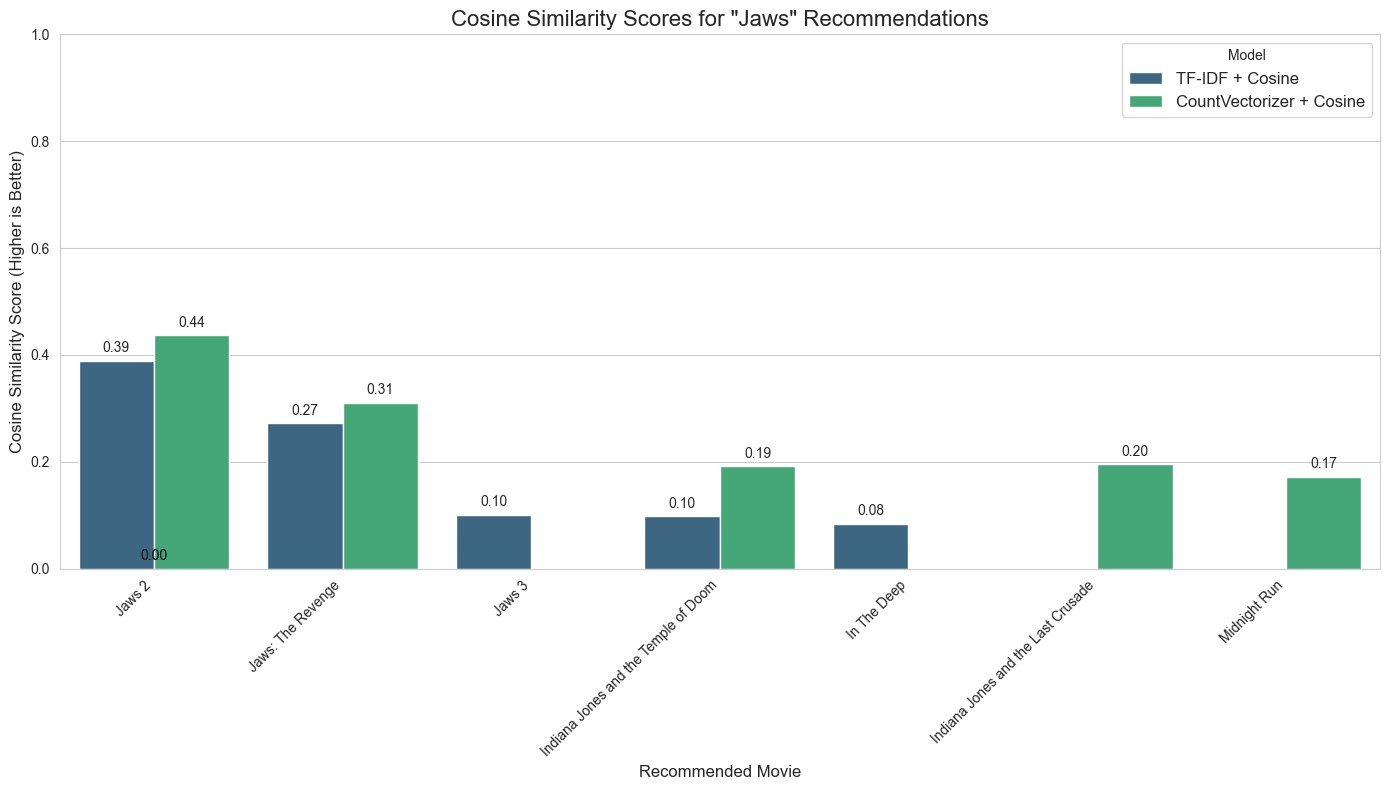

C:\Users\nickp\AppData\Local\Temp\ipykernel_20524\2698661494.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot_euclidean = sns.barplot(x='Title', y='Euclidean Distance', data=euclidean_recs, palette='mako')


Generated 'euclidean_scores_plot.png'


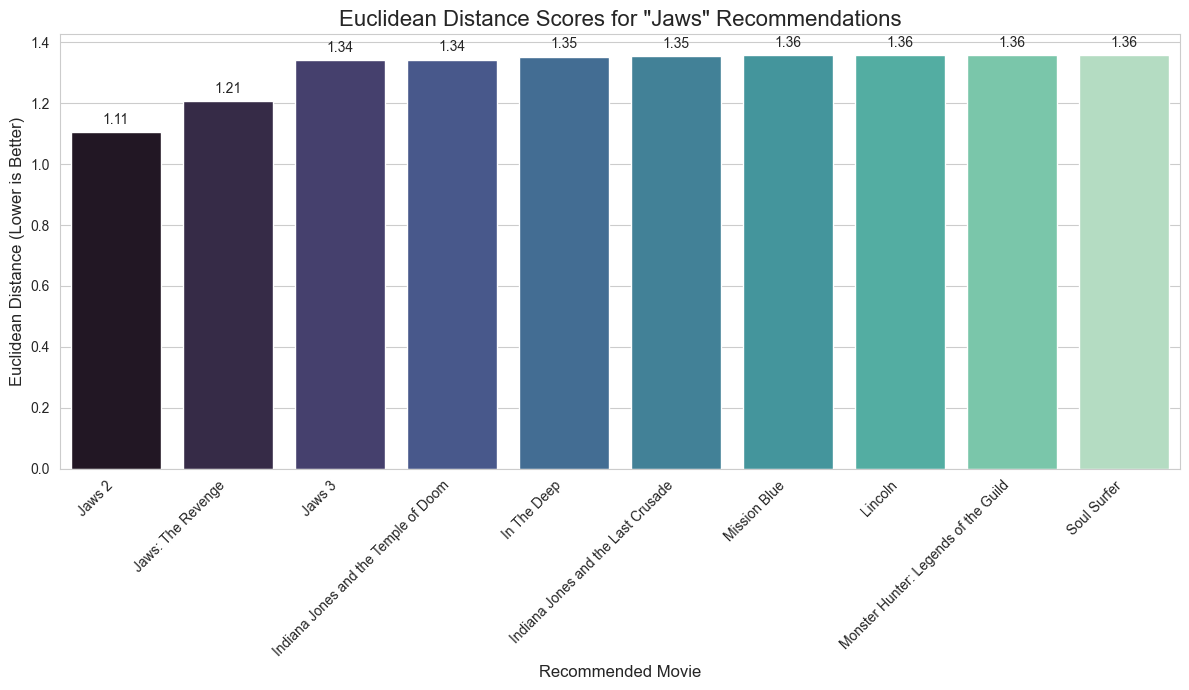

In [171]:
def plot_recommendation_scores(tfidf_recs, countvect_recs, euclidean_recs, movie_title):
    """
    Generates and saves bar charts to visualize and compare the scores
    of the top recommendations from the three different models.
    """
    
    # --- PLOT 1: Cosine Similarity Comparison (TF-IDF vs. CountVectorizer) ---
    
    # Add a 'Model' column to each dataframe to identify the source
    tfidf_recs['Model'] = 'TF-IDF + Cosine'
    countvect_recs['Model'] = 'CountVectorizer + Cosine'
    
    # Combine the two dataframes for easy plotting
    combined_cosine_recs = pd.concat([tfidf_recs, countvect_recs])
    
    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")
    
    # Create a grouped bar plot
    barplot_cosine = sns.barplot(x='Title', y='Similarity Score', hue='Model', data=combined_cosine_recs, palette='viridis')
    
    plt.title(f'Cosine Similarity Scores for "{movie_title}" Recommendations', fontsize=16)
    plt.xlabel('Recommended Movie', fontsize=12)
    plt.ylabel('Cosine Similarity Score (Higher is Better)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0) # Set y-axis limit to 1.0 for Cosine Similarity
    plt.legend(title='Model', fontsize=12)
    
    # Add the score labels on top of each bar
    for p in barplot_cosine.patches:
        barplot_cosine.annotate(format(p.get_height(), '.2f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 9), 
                               textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('cosine_scores_comparison.png')
    print("Generated 'cosine_scores_comparison.png'")
    plt.show()

    
    # --- PLOT 2: Euclidean Distance Visualization ---
    
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    
    # Create a simple bar plot for Euclidean distances
    barplot_euclidean = sns.barplot(x='Title', y='Euclidean Distance', data=euclidean_recs, palette='mako')
    
    plt.title(f'Euclidean Distance Scores for "{movie_title}" Recommendations', fontsize=16)
    plt.xlabel('Recommended Movie', fontsize=12)
    plt.ylabel('Euclidean Distance (Lower is Better)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add the score labels on top of each bar
    for p in barplot_euclidean.patches:
        barplot_euclidean.annotate(format(p.get_height(), '.2f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 9), 
                               textcoords = 'offset points')

    plt.tight_layout()
    plt.savefig('euclidean_scores_plot.png')
    print("Generated 'euclidean_scores_plot.png'")
    plt.show()


# --- HOW TO USE THE FUNCTION ---

# 1. First, make sure you have your recommendation dataframes stored in variables
movie_title = "Jaws"
tfidf_recommendations = get_recommendations(movie_title, cosine_sim=cosine_sim)
countvect_recommendations = get_recommendations(movie_title, cosine_sim=count_cosine_sim)
euclidean_recommendations = get_recommendations_by_distance(movie_title, distance_matrix=euclidean_dist)

# 2. Call the new plotting function
plot_recommendation_scores(tfidf_recommendations, countvect_recommendations, euclidean_recommendations, movie_title)



C:\Users\nickp\AppData\Local\Temp\ipykernel_20524\3453942397.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  euclidean_recs['Score'] = 1 / (1 + euclidean_recs['Euclidean Distance'])


Generated 'combined_scores_comparison.png'


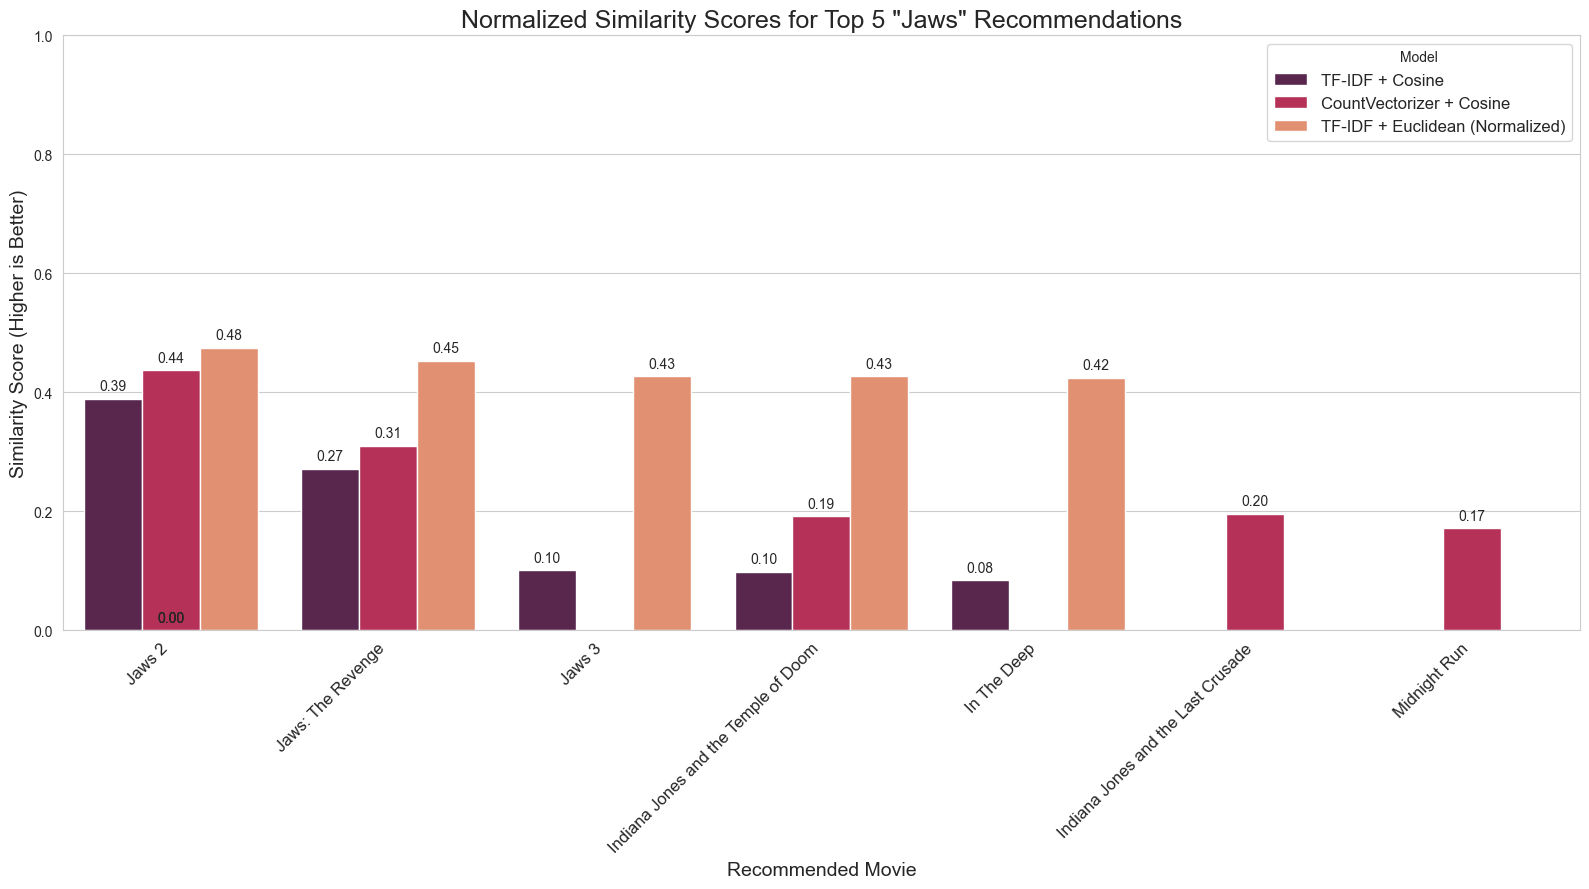

In [ ]:
def plot_combined_recommendation_scores(tfidf_recs, countvect_recs, euclidean_recs, movie_title):
    """
    Generates and saves a single, combined bar chart to visualize and compare 
    the normalized scores of the top recommendations from all three models.
    """
    
    # --- Data Preparation for Combined Plot ---
    
    # EDIT: Ensure we are only looking at the top 5 results from each model
    tfidf_recs = tfidf_recs.head(5)
    countvect_recs = countvect_recs.head(5)
    euclidean_recs = euclidean_recs.head(5)

    # Standardize column names for easy concatenation
    tfidf_recs = tfidf_recs.rename(columns={'Similarity Score': 'Score'})
    countvect_recs = countvect_recs.rename(columns={'Similarity Score': 'Score'})
    
    # Normalize Euclidean Distance to a 0-1 similarity scale
    # similarity = 1 / (1 + distance)
    euclidean_recs['Score'] = 1 / (1 + euclidean_recs['Euclidean Distance'])
    euclidean_recs = euclidean_recs.drop(columns=['Euclidean Distance'])

    # Add a 'Model' column to each dataframe to identify the source
    tfidf_recs['Model'] = 'TF-IDF + Cosine'
    countvect_recs['Model'] = 'CountVectorizer + Cosine'
    euclidean_recs['Model'] = 'TF-IDF + Euclidean (Normalized)'
    
    # Combine the three dataframes for easy plotting
    combined_recs = pd.concat([tfidf_recs, countvect_recs, euclidean_recs])
    
    # --- Create the Combined Plot ---
    
    plt.figure(figsize=(16, 9))
    sns.set_style("whitegrid")
    
    # Create a grouped bar plot with all three models
    barplot = sns.barplot(x='Title', y='Score', hue='Model', data=combined_recs, palette='rocket')
    
    plt.title(f'Normalized Similarity Scores for Top 5 "{movie_title}" Recommendations', fontsize=18)
    plt.xlabel('Recommended Movie', fontsize=14)
    plt.ylabel('Similarity Score (Higher is Better)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylim(0, 1.0) # Set y-axis limit to 1.0 for a clear similarity scale
    plt.legend(title='Model', fontsize=12)
    
    # Add the score labels on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('combined_scores_comparison.png')
    print("Generated 'combined_scores_comparison.png'")
    plt.show()


# --- HOW TO USE THE FUNCTION ---

# 1. First, make sure you have your recommendation dataframes stored in variables
movie_title = "Jaws"
tfidf_recommendations = get_recommendations(movie_title, cosine_sim=cosine_sim)
countvect_recommendations = get_recommendations(movie_title, cosine_sim=count_cosine_sim)
euclidean_recommendations = get_recommendations_by_distance(movie_title, distance_matrix=euclidean_dist)

# 2. Call the new plotting function
plot_combined_recommendation_scores(tfidf_recommendations, countvect_recommendations, euclidean_recommendations, movie_title)
# We can normalize the Euclidean distance to convert it into a similarity score 
# that is on the same scale as Cosine Similarity. A common way to do this is with the 
# formula: similarity = 1 / (1 + distance). This converts the distance score to a 0-1 scale where higher is better, 
# allowing for a fair, direct comparison on a single chart.


#### Comparison Experiments

In [163]:
print("\nRecommendations using Primary Model:")
recommendations_countvec = get_recommendations("Jaws", cosine_sim=cosine_sim)
print(recommendations_countvec)

print("\nRecommendations using CountVectorizer:")
recommendations_countvec = get_recommendations("Jaws", cosine_sim=count_cosine_sim)
print(recommendations_countvec)

print("\nRecommendations using Euclidean Distance:")
recommendations_euclidean = get_recommendations_by_distance("Jaws", distance_matrix=euclidean_dist)
print(recommendations_euclidean)


Recommendations using Primary Model:
                                     Title  Similarity Score
42                                  Jaws 2          0.389240
44                       Jaws: The Revenge          0.272087
43                                  Jaws 3          0.100751
7073  Indiana Jones and the Temple of Doom          0.098423
7061                           In The Deep          0.084164

Recommendations using CountVectorizer:
                                     Title  Similarity Score
42                                  Jaws 2          0.437042
44                       Jaws: The Revenge          0.310316
7071    Indiana Jones and the Last Crusade          0.195698
7073  Indiana Jones and the Temple of Doom          0.191663
579                           Midnight Run          0.172133

Recommendations using Euclidean Distance:
                                     Title  Euclidean Distance
42                                  Jaws 2            1.105224
44                   

In [164]:
# --- FINAL QUANTITATIVE COMPARISON ---
# Now, let's use our modified evaluation function to compare the scores
print("Calculating Genre Consistency @ 10")
calculate_genre_consistency("TF-IDF + Cosine Similarity", cosine_sim, metric_type='similarity')
calculate_genre_consistency("TF-IDF + Euclidean Distance", euclidean_dist, metric_type='distance')
calculate_genre_consistency("CountVectorizer + Cosine Similarity", count_cosine_sim, metric_type='similarity')

Calculating Genre Consistency @ 10

--- Calculating Genre Consistency for TF-IDF + Cosine Similarity ---
Result for TF-IDF + Cosine Similarity: 68.52% Genre Consistency

--- Calculating Genre Consistency for TF-IDF + Euclidean Distance ---
Result for TF-IDF + Euclidean Distance: 66.52% Genre Consistency

--- Calculating Genre Consistency for CountVectorizer + Cosine Similarity ---
Result for CountVectorizer + Cosine Similarity: 91.60% Genre Consistency


91.60000000000001


--- Generating PCA Visualization ---
Generated 'pca_recommendation_plot.png'


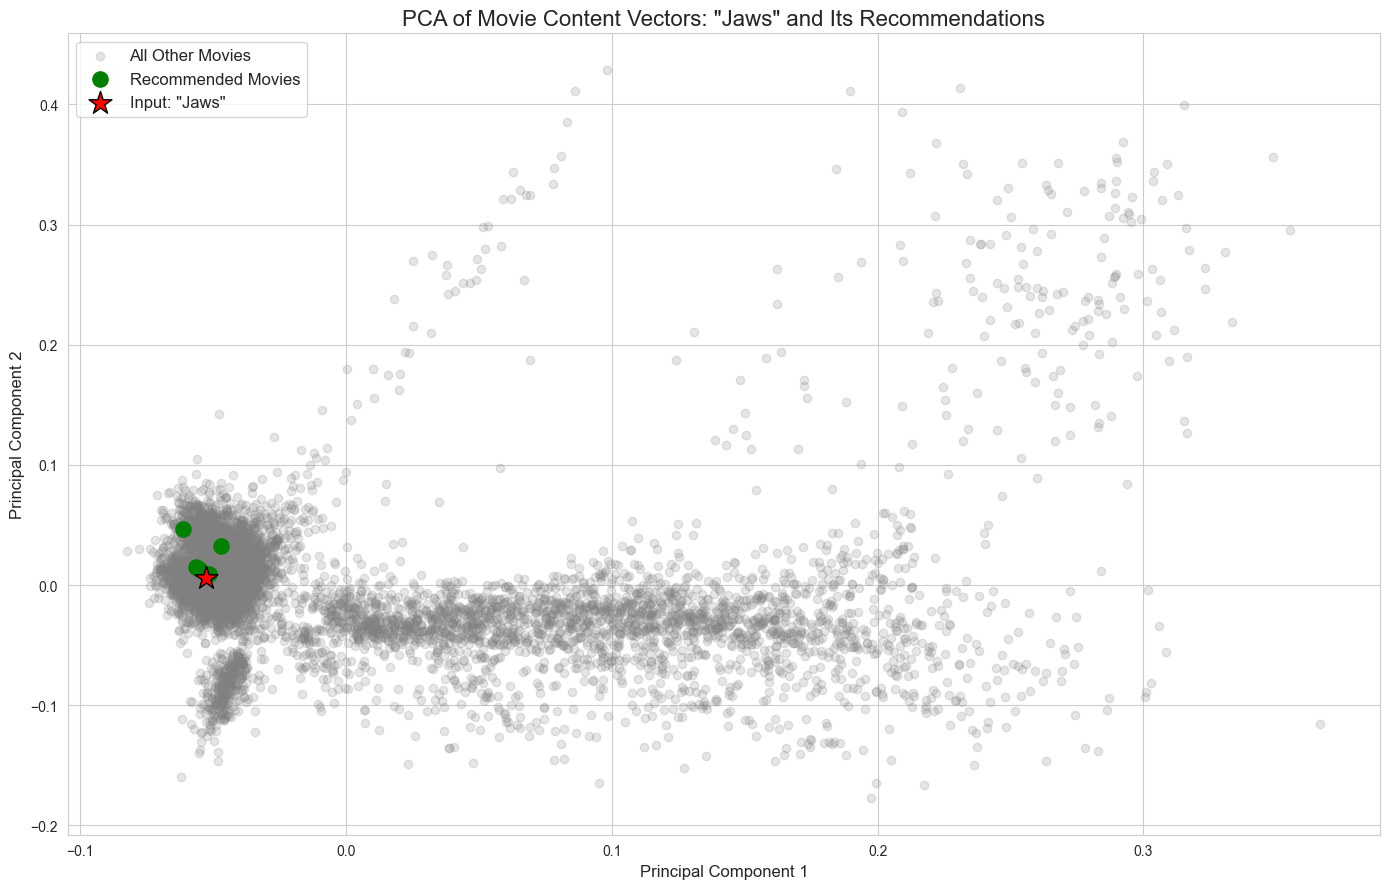

In [165]:
# --- PCA VISUALIZATION (Recommended Start) ---
# PCA is fast and great for understanding the general structure.

print("\n--- Generating PCA Visualization ---")

# 1. Apply PCA to reduce the TF-IDF matrix to 2 dimensions
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(tfidf_matrix.toarray())

# 2. Get recommendations for our test movie ("Jaws") using your best model
test_movie_title = "Jaws"
# Ensure you use the get_recommendations function with the TF-IDF + Cosine Sim model
recommendations_df = get_recommendations(test_movie_title, cosine_sim=cosine_sim)

# 3. Get the plot-ready indices for the movie and its recommendations
try:
    movie_idx = indices[test_movie_title]
    # Get the original DataFrame indices for the recommended titles
    rec_indices = recommendations_df.index.tolist()

    # 4. Create the plot
    plt.figure(figsize=(14, 9))
    sns.set_style("whitegrid")

    # Plot all movies as a faint background cloud
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.2, color='gray', label='All Other Movies')

    # Plot the recommended movies in a distinct color
    plt.scatter(principal_components[rec_indices, 0], principal_components[rec_indices, 1],
                color='green', s=120, label='Recommended Movies')

    # Plot the original movie itself with a star marker
    plt.scatter(principal_components[movie_idx, 0], principal_components[movie_idx, 1],
                color='red', s=300, marker='*', edgecolors='black', label=f'Input: "{test_movie_title}"')

    plt.title(f'PCA of Movie Content Vectors: "{test_movie_title}" and Its Recommendations', fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    # Save the figure to include in your paper
    plt.savefig('pca_recommendation_plot.png')
    print("Generated 'pca_recommendation_plot.png'")
    plt.show()

except KeyError:
    print(f"Could not generate PCA plot because '{test_movie_title}' was not found.")


Step 1: Reducing dimensions with PCA...
Step 2: Applying t-SNE...
Generated 'tsne_recommendation_plot.png'


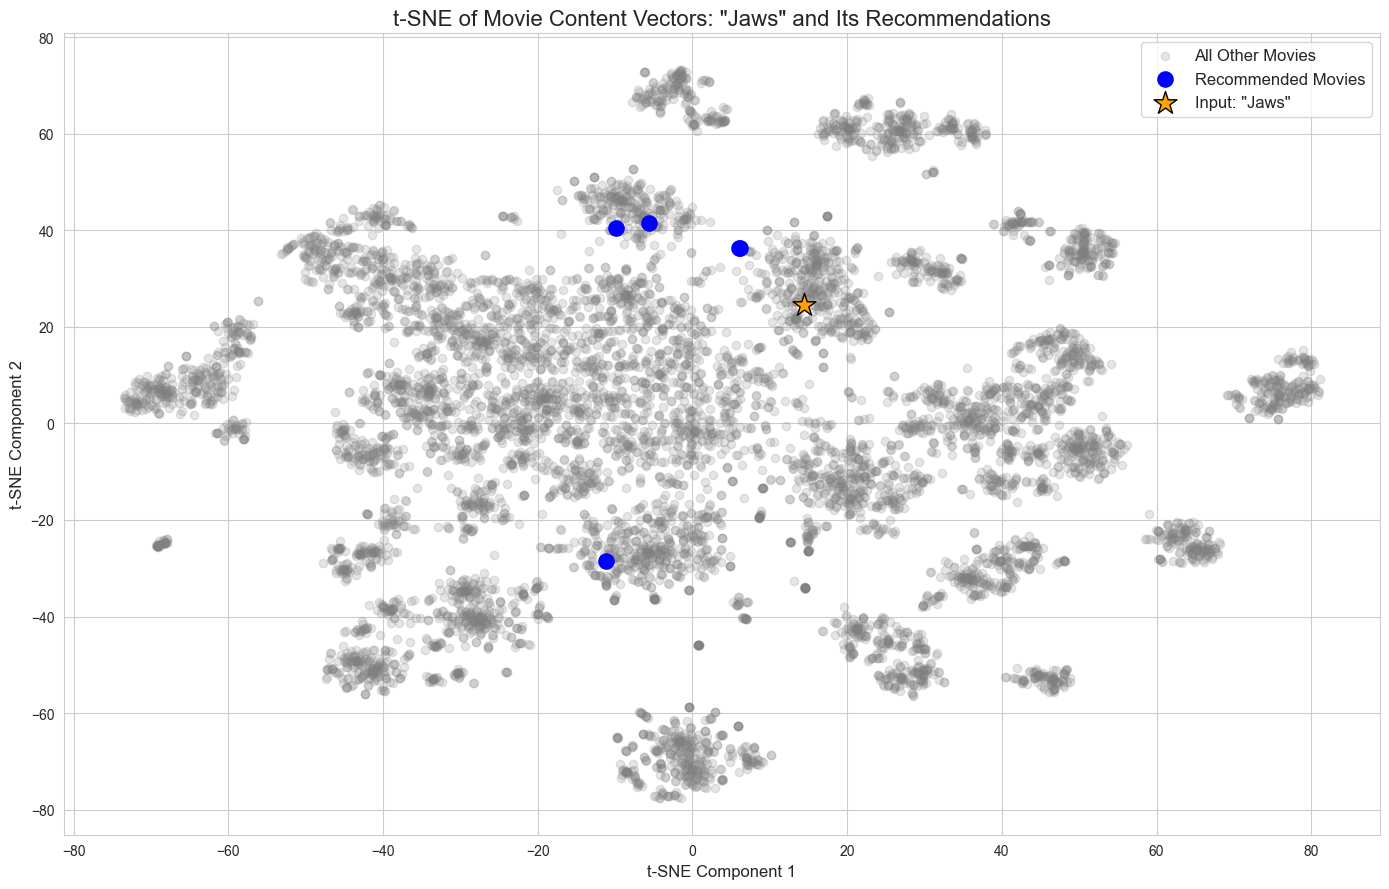

In [170]:
# 1. First, reduce dimensionality with PCA to a manageable number (e.g., 50)
# This is a crucial step to make t-SNE feasible on this large dataset.
print("Step 1: Reducing dimensions with PCA...")
pca_for_tsne = PCA(n_components=50, random_state=42)
tfidf_pca = pca_for_tsne.fit_transform(tfidf_matrix.toarray())

# 2. Now, apply t-SNE on the PCA-reduced data
print("Step 2: Applying t-SNE...")
# FIX: The 'n_iter' parameter was removed in newer versions of scikit-learn.
# The number of iterations is now controlled by 'max_iter', which defaults to 1000.
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_components = tsne.fit_transform(tfidf_pca)

# 3. The rest of the plotting code remains the same
try:
    movie_idx = indices[test_movie_title]
    rec_indices = recommendations_df.index.tolist()

    plt.figure(figsize=(14, 9))
    sns.set_style("whitegrid")
    plt.scatter(tsne_components[:, 0], tsne_components[:, 1], alpha=0.2, color='gray', label='All Other Movies')
    plt.scatter(tsne_components[rec_indices, 0], tsne_components[rec_indices, 1],
                color='blue', s=120, label='Recommended Movies')
    plt.scatter(tsne_components[movie_idx, 0], tsne_components[movie_idx, 1],
                color='orange', s=300, marker='*', edgecolors='black', label=f'Input: "{test_movie_title}"')

    plt.title(f't-SNE of Movie Content Vectors: "{test_movie_title}" and Its Recommendations', fontsize=16)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('tsne_recommendation_plot.png')
    print("Generated 'tsne_recommendation_plot.png'")
    plt.show()

except KeyError:
    print(f"Could not generate t-SNE plot because '{test_movie_title}' was not found.")


In [ ]:


# #in case needed but prob not, this is old code
# def calculate_genre_consistency(sample_size=50):
#     """
#     Calculates the average genre consistency for a random sample of movies.
#     """
#     print("\n--- Calculating Genre Consistency ---")
#     consistent_recommendations = 0
#     total_recommendations = 0

#     # Take a random sample of movies from the dataset
#     sample_df = df.sample(n=sample_size, random_state=42)

#     for index, row in sample_df.iterrows():
#         title = row['title']
#         original_genres = set(row['listed_in'].split(', '))

#         # Get recommendations for the current movie
#         recommendations = get_recommendations(title)

#         if isinstance(recommendations, pd.DataFrame): # Check if recommendations were found
#             # For each recommended movie, check if it shares a genre
#             for rec_title in recommendations['Title']:
#                 rec_genres = set(df[df['title'] == rec_title]['listed_in'].iloc[0].split(', '))
#                 # Check for any intersection between the two sets of genres
#                 if original_genres.intersection(rec_genres):
#                     consistent_recommendations += 1
#                 total_recommendations += 1

#     consistency_score = (consistent_recommendations / total_recommendations) * 100
#     print(f"Genre Consistency @10 for a sample of {sample_size} movies: {consistency_score:.2f}%")
#     return consistency_score

# # Run the evaluation
# calculate_genre_consistency()


# # movies = [
# #     "Indiana Jones and the Temple of Doom", 
# #     "Kid Cosmic", 
# #     "Blade Runner: The Final Cut", 
# #     "Dick Johnson Is Dead", 
# #     "Jailbirds New Orleans", 
# #     "Django Unchained"
# #     ]
# # for movie in movies:
# #     recommendations = get_recommendations(movie)
# #     print(f"Recommendations for '{movie}':")
# #     print(recommendations)
# #     print("")


# # movie_title = "Jaws 2"
# # recommendations = get_recommendations(movie_title)
# # print(f"Recommendations for '{movie_title}':")
# # print(recommendations)
# # # print("\n---")
# # # movie_title = "Forrest Gump"
# # # recommendations = get_recommendations(movie_title)
# # # print(f"Recommendations for '{movie_title}':")
# # # print(recommendations)
# # print("\n---")


# # # Verify that the missing values in these specific columns are filled, they should all output 0
# # print("\nMissing values after cleaning key text columns:")
# # print(df[['director', 'cast', 'date_added', 'country', 'rating', 'duration']].isnull().sum())

# #print(f"Dataset shape: {df.shape}")

# --- t-SNE VISUALIZATION (Optional - More Advanced, Slower) ---
# t-SNE is excellent at revealing local clusters but is very slow to run.
# Only run this if you have extra time and want a different style of plot.

# print("\n\n--- Generating t-SNE Visualization (This may take a few minutes) ---")
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# tsne_components = tsne.fit_transform(tfidf_matrix.toarray())

# try:
#     movie_idx = indices[test_movie_title]
#     rec_indices = recommendations_df.index.tolist()

#     plt.figure(figsize=(14, 9))
#     sns.set_style("whitegrid")
#     plt.scatter(tsne_components[:, 0], tsne_components[:, 1], alpha=0.2, color='gray', label='All Other Movies')
#     plt.scatter(tsne_components[rec_indices, 0], tsne_components[rec_indices, 1],
#                 color='blue', s=120, label='Recommended Movies')
#     plt.scatter(tsne_components[movie_idx, 0], tsne_components[movie_idx, 1],
#                 color='orange', s=300, marker='*', edgecolors='black', label=f'Input: "{test_movie_title}"')

#     plt.title(f't-SNE of Movie Content Vectors: "{test_movie_title}" and Its Recommendations', fontsize=16)
#     plt.xlabel("t-SNE Component 1", fontsize=12)
#     plt.ylabel("t-SNE Component 2", fontsize=12)
#     plt.legend(fontsize=12)
#     plt.tight_layout()
#     plt.savefig('tsne_recommendation_plot.png')
#     print("Generated 'tsne_recommendation_plot.png'")
#     plt.show()

# except KeyError:
#     print(f"Could not generate t-SNE plot because '{test_movie_title}' was not found.")